# CNN Classification of Mel Spectrograms

Tried and follow
https://www.analyticsvidhya.com/blog/2019/10/building-image-classification-models-cnn-pytorch/

In [1]:
# For Colab only
from google.colab import drive
drive.mount('content/') # /content/drive/MyDrive/bird-songs

Mounted at content/


## Training a model

In [2]:
# importing the libraries
import pandas as pd
import numpy as np
from tqdm import tqdm

# for reading and displaying images
from skimage.io import imread
import os.path
import matplotlib.pyplot as plt
%matplotlib inline

# for creating validation set
from sklearn.model_selection import train_test_split

# for evaluating the model
from sklearn.metrics import precision_score, recall_score, f1_score

# PyTorch libraries and modules
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.optim import Adam
from torch.utils.data.dataloader import DataLoader, Dataset


In [3]:
# Check whether google drive mounted
path = '/content/content/MyDrive/bird-songs'
if os.path.isdir(path) == True:
    run_on_colab = True
else:
    run_on_colab = False



if run_on_colab ==True:
    features = pd.read_csv('/content/content/MyDrive/bird-songs/features_filtered.csv', header=None, encoding='latin')
else:
    features = pd.read_csv('features_filtered.csv', encoding='latin')
features.head()

,id,gen,sp,ssp,en,cnt,loc,type,q,length,bird-seen,file,category
0,564895,Thryothorus,ludovicianus,NaN,Carolina Wren,United States,"Lyons Township (near Willow Springs), Cook Co...","adult, sex uncertain, song",no score,0:16,no,//www.xeno-canto.org/564895/download,song
1,545775,Thryothorus,ludovicianus,NaN,Carolina Wren,United States,"Valley Forge National Historical Park, Montgom...",call,no score,0:17,yes,//www.xeno-canto.org/545775/download,call
2,540857,Thryothorus,ludovicianus,NaN,Carolina Wren,United States,"Slaterville Rd @ Honness (near Ithaca), Tompk...",song,no score,0:32,unknown,//www.xeno-canto.org/540857/download,song
3,540855,Thryothorus,ludovicianus,NaN,Carolina Wren,United States,"Slaterville Rd @ Honness (near Ithaca), Tompk...",song,no score,0:52,unknown,//www.xeno-canto.org/540855/download,song
4,487506,Thryothorus,ludovicianus,NaN,Carolina Wren,United States,"Lake Artemesia Natural Area, Prince George's C...",song,no score,0:25,yes,//www.xeno-canto.org/487506/download,song


In [4]:
features['path'] = features.apply(lambda row: f'images/mel_spectrograms_8sec/{str(row.id)}.jpg', axis=1)
features.head()

,id,gen,sp,ssp,en,cnt,loc,type,q,length,bird-seen,file,category,path
0,564895,Thryothorus,ludovicianus,NaN,Carolina Wren,United States,"Lyons Township (near Willow Springs), Cook Co...","adult, sex uncertain, song",no score,0:16,no,//www.xeno-canto.org/564895/download,song,images/mel_spectrograms_8sec/564895.jpg
1,545775,Thryothorus,ludovicianus,NaN,Carolina Wren,United States,"Valley Forge National Historical Park, Montgom...",call,no score,0:17,yes,//www.xeno-canto.org/545775/download,call,images/mel_spectrograms_8sec/545775.jpg
2,540857,Thryothorus,ludovicianus,NaN,Carolina Wren,United States,"Slaterville Rd @ Honness (near Ithaca), Tompk...",song,no score,0:32,unknown,//www.xeno-canto.org/540857/download,song,images/mel_spectrograms_8sec/540857.jpg
3,540855,Thryothorus,ludovicianus,NaN,Carolina Wren,United States,"Slaterville Rd @ Honness (near Ithaca), Tompk...",song,no score,0:52,unknown,//www.xeno-canto.org/540855/download,song,images/mel_spectrograms_8sec/540855.jpg
4,487506,Thryothorus,ludovicianus,NaN,Carolina Wren,United States,"Lake Artemesia Natural Area, Prince George's C...",song,no score,0:25,yes,//www.xeno-canto.org/487506/download,song,images/mel_spectrograms_8sec/487506.jpg


In [6]:
def label_vectors(row):
    name_category = [specie_labels[row.en], category_labels[row.category]]
    label_vector = np.zeros(8)
    for idx in name_category:
        label_vector[idx] = 1
    return label_vector

# These are the top species we selected for our analysis
selected_species = ['Red-winged Blackbird', 
                    'Common Yellowthroat', 
                    'Northern Cardinal', 
                    'Carolina Wren', 
                    'Red Crossbill', 
                    'Spotted Towhee']
# We only need the id and the labels for our CNN.
dataset = features[features.en.isin(selected_species)][['id', 'en', 'category']]
# Now we need to change our labels into integers as torch does not support string format for labels.
specie_labels = {"Red-winged Blackbird": 0, 'Common Yellowthroat': 1, 'Northern Cardinal': 2, 'Carolina Wren': 3,
          'Red Crossbill': 4, 'Spotted Towhee': 5}
category_labels = {"song": 6, "call": 7}
dataset['label'] = dataset.apply(lambda row: label_vectors(row), axis=1)
dataset.drop(['en', 'category'], axis=1, inplace=True)

In [28]:
def load_images(dataset, path):
    img_df = []
    for img_name in tqdm(dataset['id']):
        # defining the image path
        if run_on_colab == True:
            image_path = f'/content/content/MyDrive/bird-songs/images/{path}/' + str(img_name) + '.jpg' 
        else:
            image_path = f'images/{path}/' + str(img_name) + '.jpg'
        # reading the image
        img = imread(image_path, as_gray=True)
         # normalizing the pixel values
        img = 2 * img - 1
        # converting the type of pixel to float 32
        img = img.astype('float32')
        # appending the image into the list
        img_df.append(img)
    
    # converting the list to numpy array
    return np.array(img_df)

## CNN - 8-second clips

If you have compatible GPU technology on your computer, you can run the CNN on it instead of CPU. 
If you are using anaconda, either create a new environment or uninstall pytorch in your current environment (if already installed) then install PyTorch with cuda:

`conda install pytorch torchvision cudatoolkit=10.2 -c pytorch`

Running this CNN on CPU takes about 17 minutes on a Dell XPS 15 9500 with 1TB SSD and 32GB RAM (2x16GB) with Windows 10. Switching to using the NVIDIA GeForce GTX 1650 it takes less than 5minutes. 

In [8]:
X, y = load_images(dataset, path='mel_spectrograms_8sec'), dataset['label'].to_numpy()
X.shape, y.shape

100%|█████████████████████████████████████████████████████████████████████████████| 2371/2371 [00:03<00:00, 644.62it/s]


((2371, 128, 345), (2371,))

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

print(X_train.shape)
print(X_test.shape)


(1896, 128, 345)
(475, 128, 345)


In [529]:
class BirdSongDataset(Dataset):
    def __init__(self):
       pass 

In [10]:
train_data = []
# Note: Conv2d layers expect input with the shape (n_samples, channels, height, width)
for i in range(len(X_train)):
    train_data.append([np.expand_dims(X_train[i], axis=0), y_train[i]]) 
test_data = []
for i in range(len(X_test)):
    test_data.append([np.expand_dims(X_test[i], axis=0), y_test[i]])

In [11]:
batch_size=50
train_dl = DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True)
test_dl = DataLoader(test_data, batch_size=batch_size, shuffle=True, drop_last=True)
# i = 0
# for x, y in test_dl:
#     print (x.size())
#     i+=1
# print(i)

In [12]:
class ImageClassifierBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        # print('out:', out)
        # print('labels:', labels)
        # print('Start loss calc')
        # criterion=nn.BCELoss()
        # loss = criterion(out, labels.type(torch.float))  # Calculate loss
        loss = F.binary_cross_entropy(out, labels.type(torch.float))
        acc = accuracy(out, labels)         # Calculate accuracy
        return loss, acc
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        # criterion=nn.BCELoss()
        # loss = criterion(out, labels.type(torch.float))   # Calculate loss
        loss = F.binary_cross_entropy(out, labels.type(torch.float))
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, train_acc: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['train_acc'], result['val_loss'], result['val_acc']))
        
def accuracy(outputs, labels, threshold=0.5):
    
    preds = np.array(outputs.cpu().detach().numpy() >= threshold, dtype=float)
    score = precision_score(labels.cpu().detach().numpy(), preds, average='micro')

    return torch.tensor(score)


In [533]:
# Scratch
# outputs = torch.tensor([0.2, 0.5, 0.6, 0.1, 0.4, 0.7])
# outputs.numpy()

# outputs = torch.tensor([0.2, 0.5, 0.6, 0.1, 0.4, 0.7])
# preds = outputs >= 0.5
# labels = torch.tensor([0,0,1,0,0,0])
# torch.sum(preds == labels)
# np.array(preds >= 0.5, dtype=float)

In [19]:
class BirdSongModel(ImageClassifierBase):
    def __init__(self):
        super().__init__()
        
        conv_layers = []

        self.conv1 = nn.Conv2d(1, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
        self.relu1 = nn.ReLU()
        self.bn1 = nn.GroupNorm(2, 32)
        nn.init.kaiming_normal_(self.conv1.weight, a=0.1)
        self.pool1 = nn.MaxPool2d(2)
        conv_layers += [self.conv1, self.relu1, self.bn1, self.pool1]

        self.conv2 = nn.Conv2d(32, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
        self.relu2 = nn.ReLU()
        self.bn2 = nn.GroupNorm(4, 64)
        nn.init.kaiming_normal_(self.conv2.weight, a=0.1)
        self.pool2 = nn.MaxPool2d(2)
        conv_layers += [self.conv2, self.relu2, self.bn2, self.pool2]
        
        self.conv3 = nn.Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.relu3 = nn.ReLU()
        nn.init.kaiming_normal_(self.conv3.weight, a=0.1)
        self.pool3 = nn.MaxPool2d(2)
        conv_layers += [self.conv3, self.relu3, self.pool3]

        self.conv4 = nn.Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.relu4 = nn.ReLU()
        nn.init.kaiming_normal_(self.conv4.weight, a=0.1)
        self.pool4 = nn.MaxPool2d(2)
        conv_layers += [self.conv4, self.relu4, self.pool4]
        
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(256*2*5, 50)
        self.relufc1 = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.linear2 = nn.Linear(50, 10)
        self.relufc2 = nn.ReLU()
        self.linear3 = nn.Linear(10, 8)
        self.sigmoid = nn.Sigmoid()
        conv_layers += [self.flatten, self.linear1, self.relufc1, self.dropout,
                        self.linear2, self.relufc2, self.linear3, self.sigmoid]
        
        self.network = nn.Sequential(*conv_layers)
        

    def forward(self, x):

        return self.network(x)
        


In [20]:
# Helper functions to have option of running with GPU or CPU
def get_default_device():
    """Create device: Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) of data to chosen device"""
    # If list of tensors
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    # else if single tensor
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to yield data to device as
    the batches are requested"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [21]:
# Helper functions to fit and evaluate model
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        train_accuracies = []
        for batch in train_loader:
            # Zero gradients
            optimizer.zero_grad()
            # Calculate loss
            loss, acc = model.training_step(batch)
            train_losses.append(loss)
            train_accuracies.append(acc)
            # Back-propogate loss
            loss.backward()
            # Update weights
            optimizer.step()
            
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['train_acc'] = torch.stack(train_accuracies).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [22]:
device = get_default_device()
# print(device)
model = to_device(BirdSongModel(), device)

# Wrap training and test data loaders using `DeviceDataLoader` for automatically
# transferring batches of data to the GPU (if available), and use `to_device` 
# to move our model to the GPU (if available).
train_dl = DeviceDataLoader(train_dl, device)
test_dl = DeviceDataLoader(test_dl, device)
to_device(model, device);

# evaluate(model, test_dl)

num_epochs = 100
opt_func = torch.optim.Adam
lr = 0.00004

In [538]:
# for layer in model.children():
#     if hasattr(layer, 'reset_parameters'):
#         print(f'Reset trainable parameters of layer = {layer}')
#         layer.reset_parameters()

In [23]:
history = fit(num_epochs, lr, model, train_dl, test_dl, opt_func)

Epoch [0], train_loss: 0.6720, train_acc: 0.2820, val_loss: 0.6547, val_acc: 0.2416
Epoch [1], train_loss: 0.6591, train_acc: 0.2937, val_loss: 0.6501, val_acc: 0.3185
Epoch [2], train_loss: 0.6542, train_acc: 0.2849, val_loss: 0.6472, val_acc: 0.2811
Epoch [3], train_loss: 0.6471, train_acc: 0.3027, val_loss: 0.6372, val_acc: 0.3344
Epoch [4], train_loss: 0.6391, train_acc: 0.3184, val_loss: 0.6310, val_acc: 0.3259
Epoch [5], train_loss: 0.6328, train_acc: 0.3393, val_loss: 0.6218, val_acc: 0.3384
Epoch [6], train_loss: 0.6255, train_acc: 0.3446, val_loss: 0.6168, val_acc: 0.3585
Epoch [7], train_loss: 0.6178, train_acc: 0.3514, val_loss: 0.6104, val_acc: 0.3942
Epoch [8], train_loss: 0.6111, train_acc: 0.3508, val_loss: 0.6034, val_acc: 0.3922
Epoch [9], train_loss: 0.6003, train_acc: 0.3751, val_loss: 0.5901, val_acc: 0.3940
Epoch [10], train_loss: 0.5961, train_acc: 0.3798, val_loss: 0.5842, val_acc: 0.4282
Epoch [11], train_loss: 0.5883, train_acc: 0.3895, val_loss: 0.5776, val_ac

Epoch [97], train_loss: 0.2476, train_acc: 0.8658, val_loss: 0.3699, val_acc: 0.8216
Epoch [98], train_loss: 0.2423, train_acc: 0.8636, val_loss: 0.3851, val_acc: 0.8090
Epoch [99], train_loss: 0.2447, train_acc: 0.8589, val_loss: 0.3731, val_acc: 0.8238


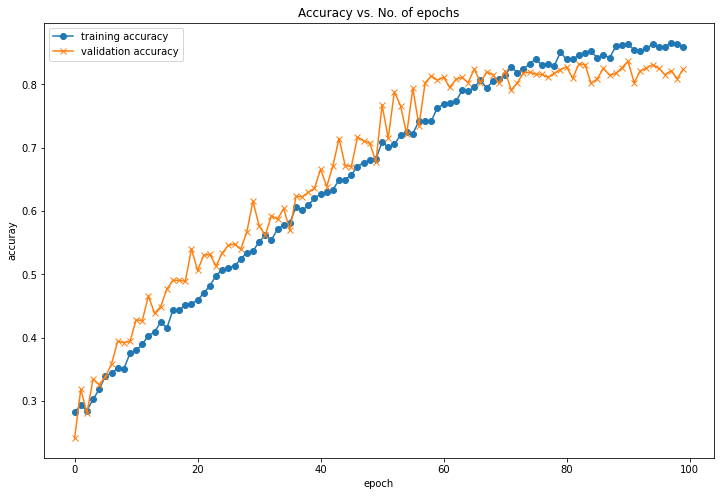

In [24]:
def plot_accuracies(history):

    train_accuracies = [x['train_acc'] for x in history]
    val_accuracies = [x['val_acc'] for x in history]
    plt.figure(figsize=(12, 8))
    plt.plot(train_accuracies, '-o', label='training accuracy')
    plt.plot(val_accuracies, '-x', label='validation accuracy')
    plt.xlabel('epoch')
    plt.ylabel('accuray')
    plt.title('Accuracy vs. No. of epochs')
    plt.legend()

plot_accuracies(history);

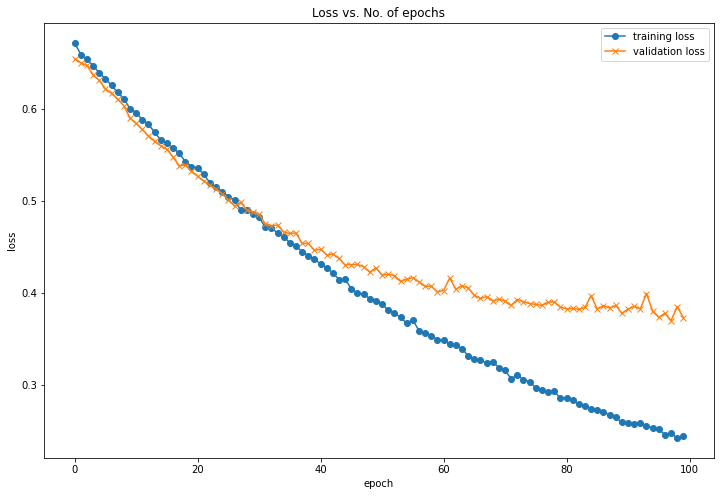

In [25]:
def plot_loss(history):

    train_accuracies = [x['train_loss'] for x in history]
    val_accuracies = [x['val_loss'] for x in history]
    plt.figure(figsize=(12, 8))
    plt.plot(train_accuracies, '-o', label='training loss')
    plt.plot(val_accuracies, '-x', label='validation loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('Loss vs. No. of epochs')
    plt.legend()

plot_loss(history);

In [330]:
torch.save(model.state_dict(), "filename.pth")
print("mdoel training and stored at filename.pth")

mdoel training and stored at filename.pth


# Scratch

In [54]:
# dataiter = iter(train_dl)
# images, labels = dataiter.next()
# print (images[0].shape)

In [351]:
# # Test the model on the first batch from the training dataloader
# model=BirdSongModel()
# for images, labels in train_dl:
#     print(labels)
#     print('images.shape:', images.shape)
#     out = model(images)
#     print('out.shape:', out.shape)
#     print('out[0]:', out[0])
#     print('sum out[0]:', torch.sum(out[0]).item())

#     break

# CNN - Best Clips 2 seconds

In [29]:
X, y = load_images(dataset, path='mel_spectrograms_best_clip'), dataset['label'].to_numpy()
X.shape, y.shape

100%|████████████████████████████████████████████████████████████████████████████| 2371/2371 [00:02<00:00, 1043.90it/s]


((2371, 128, 87), (2371,))

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

print(X_train.shape)
print(X_test.shape)

(1896, 128, 87)
(475, 128, 87)


In [88]:
train_data = []
# Note: Conv2d layers expect input with the shape (n_samples, channels, height, width)
for i in range(len(X_train)):
    train_data.append([np.expand_dims(X_train[i], axis=0), y_train[i]]) 
test_data = []
for i in range(len(X_test)):
    test_data.append([np.expand_dims(X_test[i], axis=0), y_test[i]])

In [89]:
batch_size=50
train_dl = DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True)
test_dl = DataLoader(test_data, batch_size=batch_size, shuffle=True, drop_last=True)

In [62]:
class ImageClassifierBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        # print('out:', out)
        # print('labels:', labels)
        # print('Start loss calc')
        # criterion=nn.BCELoss()
        # loss = criterion(out, labels.type(torch.float))  # Calculate loss
        loss = F.binary_cross_entropy(out, labels.type(torch.float))
        acc = accuracy(out, labels)         # Calculate accuracy
        return loss, acc
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        # criterion=nn.BCELoss()
        # loss = criterion(out, labels.type(torch.float))   # Calculate loss
        loss = F.binary_cross_entropy(out, labels.type(torch.float))
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, train_acc: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['train_acc'], result['val_loss'], result['val_acc']))
        
def accuracy(outputs, labels, threshold=0.5):
    
    preds = np.array(outputs.cpu().detach().numpy() >= threshold, dtype=float)
    score = precision_score(labels.cpu().detach().numpy(), preds, average='micro')

    return torch.tensor(score)

In [86]:
# # Test image size
# simple_model = nn.Sequential(
#     nn.Conv2d(1, 8, kernel_size=2, stride=1, padding=0),
#     nn.ReLU(),
#     nn.MaxPool2d(2),
#     nn.Conv2d(8, 16, kernel_size=2, stride=1, padding=0),
#     nn.ReLU(),
#     nn.MaxPool2d(2),

#     nn.Conv2d(16, 32, kernel_size=1, stride=1, padding=0),
#     nn.ReLU(),
#     nn.MaxPool2d(2),
#     nn.Conv2d(32, 64, kernel_size=1, stride=1, padding=0),
#     nn.ReLU(),
#     nn.MaxPool2d(2),

# #     nn.Flatten(), 
# #     nn.Linear(256*3*7, 1024),
# #     nn.ReLU(),
# #     nn.Linear(1024, 5)
# )
# for images, labels in train_dl:
#     print('images.shape:', images.shape)
#     out = simple_model(images)
#     print('out.shape:', out.shape)
#     break

images.shape: torch.Size([50, 1, 128, 87])
out.shape: torch.Size([50, 64, 7, 5])


In [90]:
class BirdSongModel(ImageClassifierBase):
    def __init__(self):
        super().__init__()
        
        conv_layers = []

        self.conv1 = nn.Conv2d(1, 8, kernel_size=(2, 2), stride=(1, 1), padding=(0, 0))
        self.relu1 = nn.ReLU()
        self.bn1 = nn.GroupNorm(2, 8)
        nn.init.kaiming_normal_(self.conv1.weight, a=0.1)
        self.pool1 = nn.MaxPool2d(2)
        conv_layers += [self.conv1, self.relu1, self.bn1, self.pool1]

        self.conv2 = nn.Conv2d(8, 16, kernel_size=(2, 2), stride=(1, 1), padding=(0, 0))
        self.relu2 = nn.ReLU()
        self.bn2 = nn.GroupNorm(4, 16)
        nn.init.kaiming_normal_(self.conv2.weight, a=0.1)
        self.pool2 = nn.MaxPool2d(2)
        conv_layers += [self.conv2, self.relu2, self.bn2, self.pool2]
        
        self.conv3 = nn.Conv2d(16, 32, kernel_size=(1, 1), stride=(1, 1), padding=(0, 0))
        self.relu3 = nn.ReLU()
        nn.init.kaiming_normal_(self.conv3.weight, a=0.1)
        self.pool3 = nn.MaxPool2d(2)
        conv_layers += [self.conv3, self.relu3, self.pool3]

        self.conv4 = nn.Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1), padding=(0, 0))
        self.relu4 = nn.ReLU()
        nn.init.kaiming_normal_(self.conv4.weight, a=0.1)
        self.pool4 = nn.MaxPool2d(2)
        conv_layers += [self.conv4, self.relu4, self.pool4]
        
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(64*7*5, 50)
        self.relufc1 = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.linear2 = nn.Linear(50, 10)
        self.relufc2 = nn.ReLU()
        self.linear3 = nn.Linear(10, 8)
        self.sigmoid = nn.Sigmoid()
        conv_layers += [self.flatten, self.linear1, self.relufc1, self.dropout,
                        self.linear2, self.relufc2, self.linear3, self.sigmoid]
        
        self.network = nn.Sequential(*conv_layers)
        

    def forward(self, x):

        return self.network(x)

In [68]:
# Helper functions to have option of running with GPU or CPU
def get_default_device():
    """Create device: Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) of data to chosen device"""
    # If list of tensors
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    # else if single tensor
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to yield data to device as
    the batches are requested"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [69]:
# Helper functions to fit and evaluate model
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        train_accuracies = []
        for batch in train_loader:
            # Zero gradients
            optimizer.zero_grad()
            # Calculate loss
            loss, acc = model.training_step(batch)
            train_losses.append(loss)
            train_accuracies.append(acc)
            # Back-propogate loss
            loss.backward()
            # Update weights
            optimizer.step()
            
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['train_acc'] = torch.stack(train_accuracies).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [91]:
device = get_default_device()
# print(device)
model = to_device(BirdSongModel(), device)

# Wrap training and test data loaders using `DeviceDataLoader` for automatically
# transferring batches of data to the GPU (if available), and use `to_device` 
# to move our model to the GPU (if available).
train_dl = DeviceDataLoader(train_dl, device)
test_dl = DeviceDataLoader(test_dl, device)
to_device(model, device);

# evaluate(model, test_dl)

num_epochs = 100
opt_func = torch.optim.Adam
lr = 0.00004

In [92]:
history = fit(num_epochs, lr, model, train_dl, test_dl, opt_func)

Epoch [0], train_loss: 0.6830, train_acc: 0.2624, val_loss: 0.6504, val_acc: 0.2796
Epoch [1], train_loss: 0.6556, train_acc: 0.2724, val_loss: 0.6310, val_acc: 0.2747
Epoch [2], train_loss: 0.6483, train_acc: 0.2650, val_loss: 0.6226, val_acc: 0.2722
Epoch [3], train_loss: 0.6380, train_acc: 0.2868, val_loss: 0.6151, val_acc: 0.2920
Epoch [4], train_loss: 0.6318, train_acc: 0.2972, val_loss: 0.6108, val_acc: 0.2921
Epoch [5], train_loss: 0.6277, train_acc: 0.2982, val_loss: 0.6048, val_acc: 0.2987
Epoch [6], train_loss: 0.6192, train_acc: 0.3123, val_loss: 0.5981, val_acc: 0.3051
Epoch [7], train_loss: 0.6151, train_acc: 0.3132, val_loss: 0.5955, val_acc: 0.3044
Epoch [8], train_loss: 0.6091, train_acc: 0.3283, val_loss: 0.5905, val_acc: 0.3178
Epoch [9], train_loss: 0.6055, train_acc: 0.3364, val_loss: 0.5853, val_acc: 0.3239
Epoch [10], train_loss: 0.5975, train_acc: 0.3443, val_loss: 0.5807, val_acc: 0.3435
Epoch [11], train_loss: 0.5937, train_acc: 0.3598, val_loss: 0.5757, val_ac

Epoch [97], train_loss: 0.4034, train_acc: 0.7381, val_loss: 0.4353, val_acc: 0.7086
Epoch [98], train_loss: 0.4041, train_acc: 0.7409, val_loss: 0.4340, val_acc: 0.7108
Epoch [99], train_loss: 0.4038, train_acc: 0.7428, val_loss: 0.4352, val_acc: 0.7138


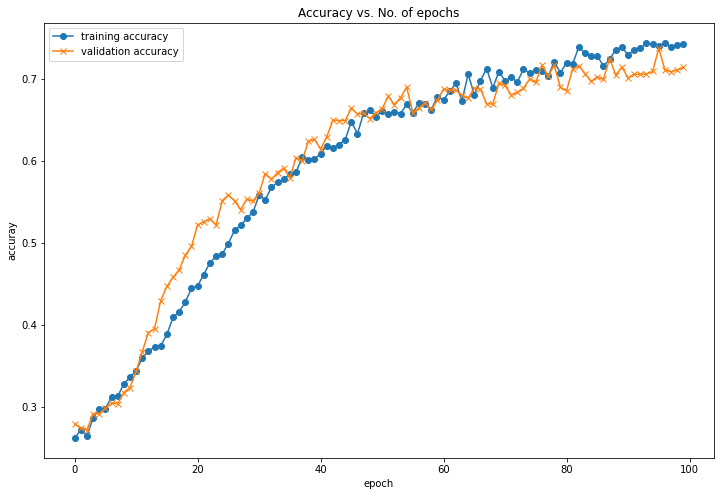

In [93]:
plot_accuracies(history);

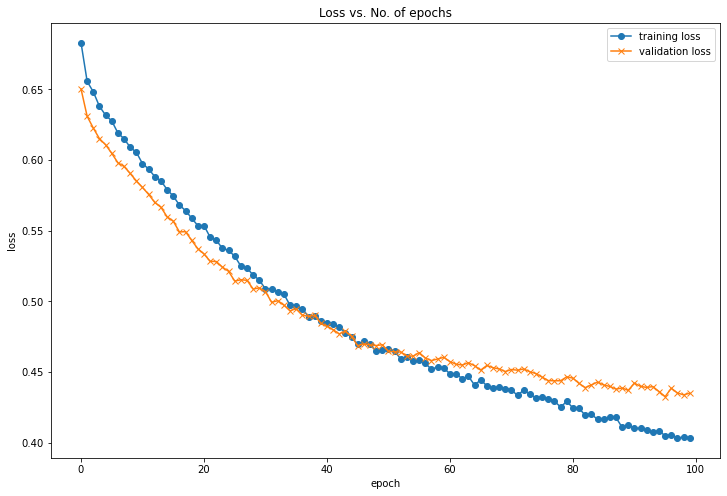

In [94]:
plot_loss(history);